<a href="https://colab.research.google.com/github/MuskanRastogi5/Pothole-Speed-breaker-and-cobblestone-detection-using-ML-model/blob/main/final_pothole_muskan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D, MaxPooling1D,GlobalAveragePooling1D,GlobalAvgPool1D, Reshape, Activation
from keras import optimizers
# tf.disable_v2_behavior()

%matplotlib inline
plt.style.use('ggplot')

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_data(file_path):
    print("reading data")

    column_names = ['timestamp',	'uniqueId',	'latitude','longitude',	'speed',	'heading',	'cellId',	'accuracy',	'altitude',	'areaCode',	'cellIdSignalStrength',	'hdop',	'numberOfSatellites',	'internalBatteryVoltage',	'internalBatteryLevel',	'gsmlevel',	'accelerometerX',	'accelerometerY',	'accelerometerZ',	'gyroX',	'gyroY',	'gyroZ',	'locationSource',	'power',	'sos',	'isNavigating',	'gpsState',	'gprsState',	'mockLocation',	'proximity_sensor',	'barometer_sensor',	'temperature_sensor',	'light_sensor',	'device_state',	'isAeroplaneMode',	'gprs_type',	'gender',	'vehicle_type',	'callStatus',	'wifiStrength',	'isSyncedToServer',	'tripStatus',	'srno',	'time',	'acceleration',	'acceleration_deviation',	'predicted_Zstatus']
    # column_names = ['uniqueId','timestamp', 'accelerometerX', 'accelerometerY', 'accelerometerZ','predicted_Zstatus']
    data = pd.read_csv(file_path,header = None, names = column_names)
    print("finished reading data")
    return data

In [ ]:
def feature_normalize(dataset):
    mu = np.mean(dataset.astype(float).abs(),axis = 0)
    sigma = np.std(dataset.astype(float).abs(),axis = 0)
    return (dataset.astype(float).abs() - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    

In [ ]:
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['accelerometerX'], 'accelerometerX')
    plot_axis(ax1, data['timestamp'], data['accelerometerY'], 'accelerometerY')
    plot_axis(ax2, data['timestamp'], data['accelerometerZ'], 'accelerometerZ')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.pause(0.5)
    plt.show(block=False)
    fig.savefig(activity +'.png')

In [ ]:
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

In [ ]:
def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))

    for (start, end) in windows(data["timestamp"], window_size):
        x = data["accelerometerX"][start:end]
        y = data["accelerometerY"][start:end]
        z = data["accelerometerZ"][start:end]
        if(len(dataset["timestamp"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["predicted_Zstatus"][start:end])[0][0])

    return segments, labels

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [ ]:
column_names = ['timestamp',	'uniqueId',	'latitude','longitude',	'speed',	'heading',	'cellId',	'accuracy',	'altitude',	'areaCode',	'cellIdSignalStrength',	'hdop',	'numberOfSatellites',	'internalBatteryVoltage',	'internalBatteryLevel',	'gsmlevel',	'accelerometerX',	'accelerometerY',	'accelerometerZ',	'gyroX',	'gyroY',	'gyroZ',	'locationSource',	'power',	'sos',	'isNavigating',	'gpsState',	'gprsState',	'mockLocation',	'proximity_sensor',	'barometer_sensor',	'temperature_sensor',	'light_sensor',	'device_state',	'isAeroplaneMode',	'gprs_type',	'gender',	'vehicle_type',	'callStatus',	'wifiStrength',	'isSyncedToServer',	'tripStatus',	'srno',	'time',	'acceleration',	'acceleration_deviation',	'predicted_Zstatus']
dataset = pd.read_csv('/content/samsung_data_analysis_new - samsung_data_analysis.csv', names = column_names)

# dataset[column_names] = dataset[column_names].apply(lambda x: float(x.split()[0].replace(',', '')))

# data[column_names] = data[column_names].replace('[^0-9.]', '', regex=True).astype(float)
# dataset[column_names] = dataset[column_names].apply(lambda x: float(x.split()[0].replace(',', '')) if isinstance(x, str) and x.strip() != '' else 0.0)


# dataset = pd.read_csv( '/content/drive/My Drive/samsung_data_analysis.csv')

dataset.dropna(axis=0, how='any', inplace= True)
print("normalizing x")
dataset['accelerometerX'] = feature_normalize(dataset['accelerometerX'][1:])
print("normalizing y")
dataset['accelerometerY'] = feature_normalize(dataset['accelerometerY'][1:])
print("normalizing z")
dataset['accelerometerZ'] = feature_normalize(dataset['accelerometerZ'][1:])

normalizing x
normalizing y
normalizing z


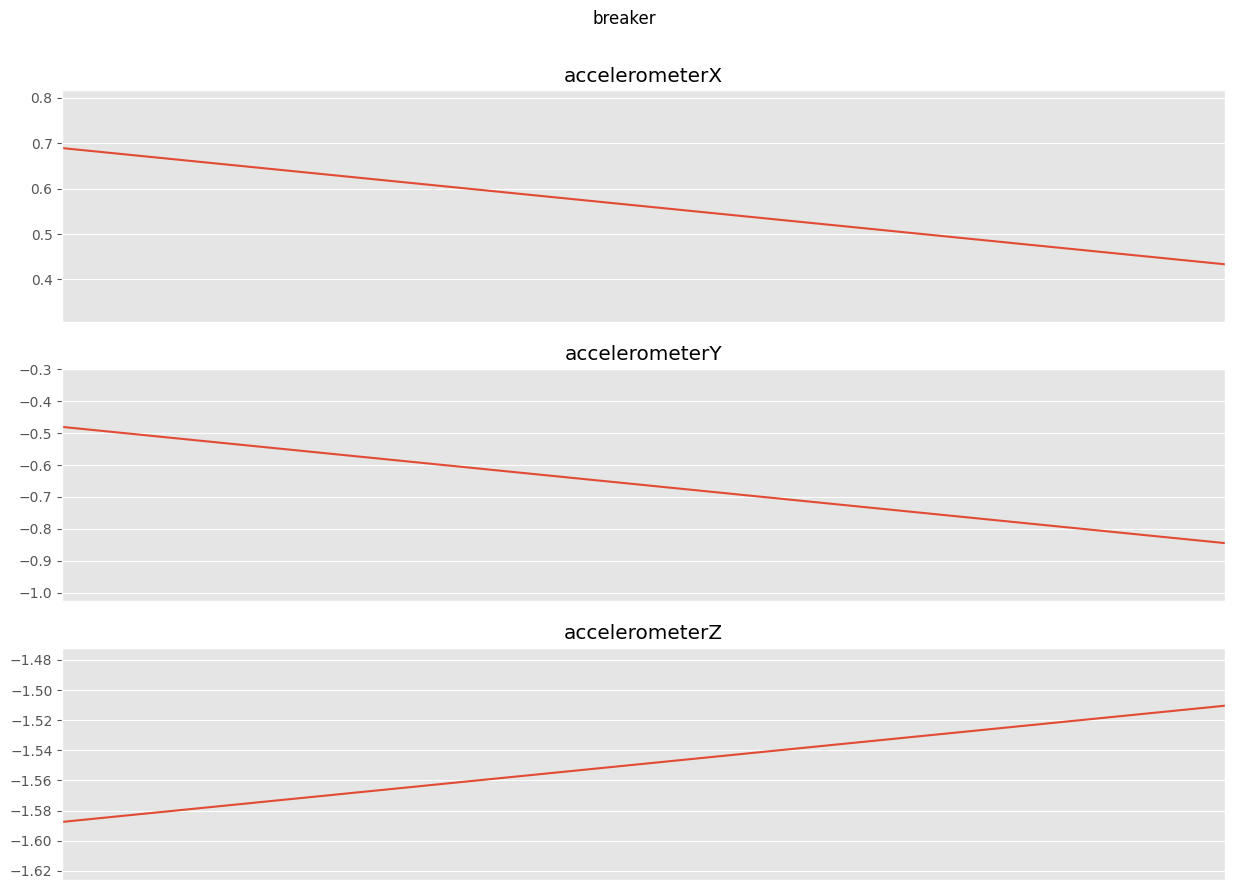

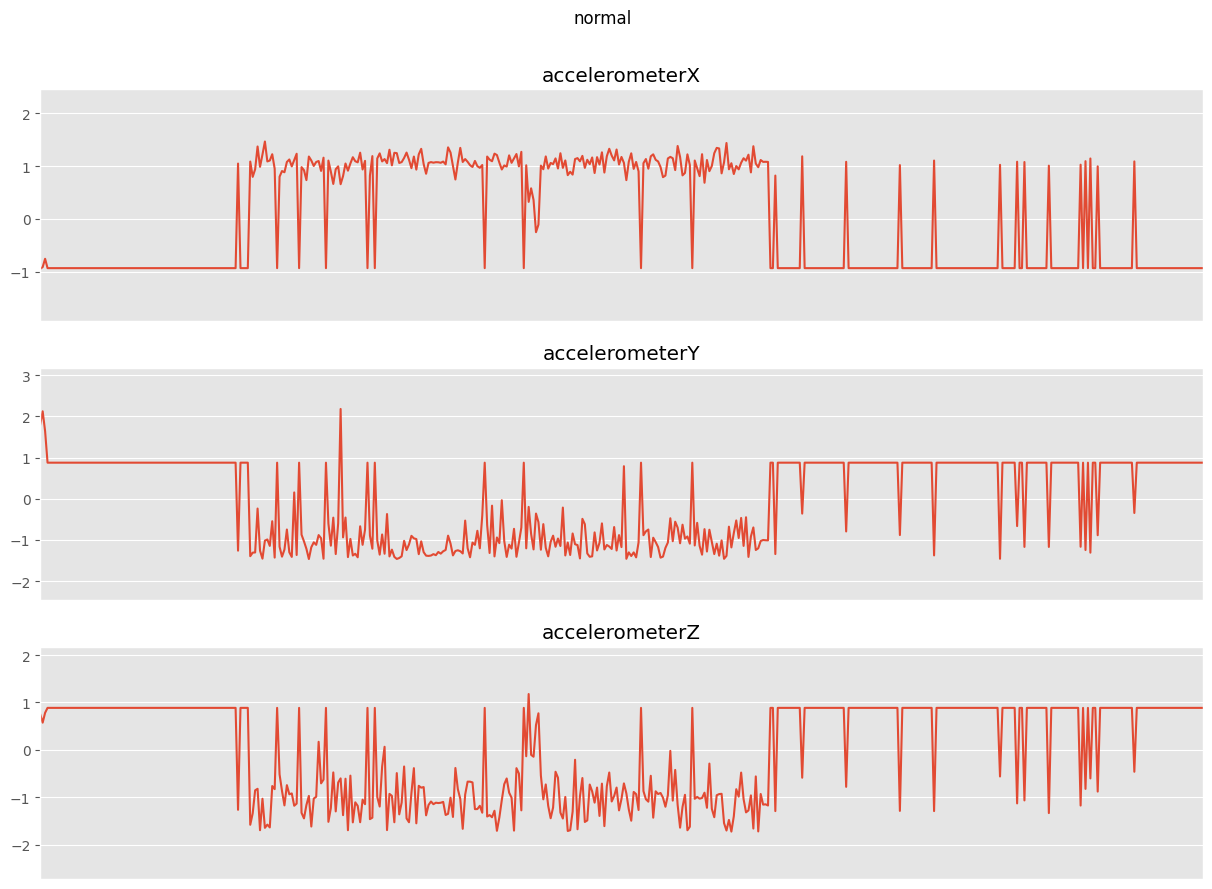

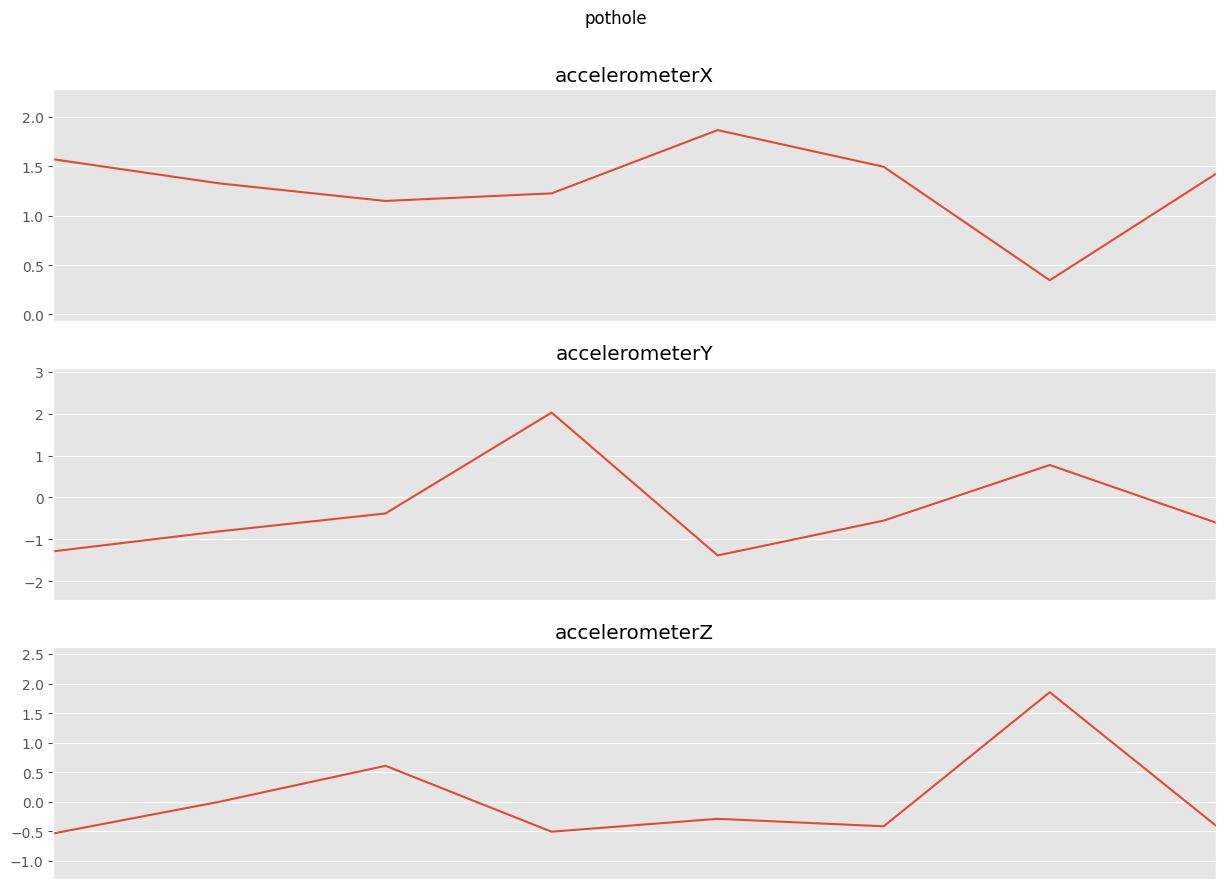

In [ ]:
for activity in np.unique(dataset["predicted_Zstatus"]):
    dataset.dropna(inplace=True)
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
    subset = dataset[dataset["predicted_Zstatus"] == activity]
    plot_activity(activity,subset)

In [ ]:
segments, labels = segment_signal(dataset, 90)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

<ipython-input-7-6a3edac3c759>:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels = np.append(labels,stats.mode(data["predicted_Zstatus"][start:end])[0][0])
<ipython-input-7-6a3edac3c759>:11: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  labels = np.append(labels,stats.mode(data["predicted_Zstatus"][start:end])[0][0])


In [ ]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
print(train_x.shape)
train_y = labels[train_test_split]
print(train_y.shape)
test_x = reshaped_segments[~train_test_split]

test_y = labels[~train_test_split]

(8, 1, 90, 3)
(8, 1)


In [ ]:
input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 8

total_batches = train_x.shape[0] // batch_size

In [ ]:
trainSplitRatio = 0.7 # split ratio for test and validation
window_size = 90 #Length of time slice. Actitrac was recorded at 20Hz
numFilters1 = 100 # number of filters in first Conv1D layer
kernalSize = 10 # kernal size of the Conv2D layer
batchSize = 10
numNueronsFCL2 = 160 # number of filters in fully connected output layer
dropout = 0.5 #dropout rate. % of neurons converted to 0 weight before softmax
epochs = 50

In [ ]:
numOfRows = segments.shape[1]
print(numOfRows)
numOfColumns = segments.shape[2]
print(numOfColumns)
print(train_x.shape[2])
print(train_y.shape[1])
num_classes = labels.shape[1]
num_data_parameters = train_x.shape[3]
input_shape = window_size*num_data_parameters

90
3
90
1


In [ ]:
model_m = Sequential()
model_m.add(Reshape((window_size, num_data_parameters), input_shape=(1,numOfRows,numOfColumns)))
model_m.add(Conv1D(numFilters1, kernalSize, activation='relu', input_shape=(window_size, num_data_parameters)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(numNueronsFCL2, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())

model_m.add(Dropout(dropout))

model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 90, 3)             0         
                                                                 
 conv1d (Conv1D)             (None, 81, 100)           3100      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 100)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 160)           160160    
                                                                 
 global_average_pooling1d (G  (None, 160)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 160)               0

In [ ]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [ ]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
accuracy

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [ ]:
#cost_history = np.empty(shape=[1],dtype=float)
#with tf.Session() as session:
#    print(total_batches)
 #   tf.global_variables_initializer().run()
  #  for epoch in range(8):
   #     for b in range(10): 
    #        offset = (b * batch_size) % (train_y.shape[0] - batch_size)
     #       batch_x = train_x[offset:(offset + batch_size), :, :, :]
      #      batch_y = train_y[offset:(offset + batch_size), :]
       #     _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
        #    cost_history = np.append(cost_history,c)

print ("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
print ("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

NameError: ignored